In [1]:
# Import required libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Add project root to path for imports
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules from new structure
from configs.config import Config
from src.utils.data_utils import (
    load_triplet_csv, 
    TripletSignLanguageDataset, 
    create_triplet_data_loaders,
)
from src.utils.model_utils import (
    create_adjacency_matrix,
    create_model,
    create_triplet_model,
    load_model
)
from src.models.model import (
    HGC_LSTM
)
from src.models.triplet import (
    TripletNet
)
from src.utils.train_utils import (
    train_model_triplet
)
from src.utils.visualization_utils import (
    visualize_training_process,
    analyze_model_performance
)

print("✅ All modules imported successfully!")
print(f"📦 Project structure reorganized with modular imports")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Device: {torch.cuda.get_device_name(0)}")
print()

# Initialize configuration
config = Config()
print("🔧 Configuration loaded from configs/config.py")
print(f"📊 Data from: {config.data.input_kp_path}")
print(f"💾 Models save to: {config.model.checkpoint_dir}")
print(f"📈 Plots save to: {config.output.plots_dir}")

✅ All modules imported successfully!
📦 Project structure reorganized with modular imports
🐍 Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
🔥 PyTorch: 2.7.0+cu126
🔧 CUDA Available: True
🔧 CUDA Device: NVIDIA GeForce RTX 3070 Ti

🔧 Configuration loaded from configs/config.py
📊 Data from: dataset/Keypoints
💾 Models save to: outputs/models
📈 Plots save to: outputs/plots


In [2]:
# Import data utilities
from src.utils.data_utils import load_labels_from_csv

# Load labels
triplet_data = load_triplet_csv(None, config)
triplet_data

[(1, '1_01', '1_02', '12_13'),
 (1, '1_01', '1_03', '8_20'),
 (1, '1_01', '1_04', '13_12'),
 (1, '1_01', '1_05', '10_20'),
 (1, '1_01', '1_06', '6_01'),
 (1, '1_01', '1_07', '9_14'),
 (1, '1_01', '1_08', '14_07'),
 (1, '1_01', '1_09', '6_16'),
 (1, '1_01', '1_10', '3_03'),
 (1, '1_01', '1_11', '12_17'),
 (1, '1_01', '1_12', '8_18'),
 (1, '1_01', '1_13', '13_06'),
 (1, '1_01', '1_14', '13_17'),
 (1, '1_01', '1_15', '7_19'),
 (1, '1_01', '1_16', '5_11'),
 (1, '1_01', '1_17', '1_17'),
 (1, '1_01', '1_18', '12_02'),
 (1, '1_01', '1_19', '5_13'),
 (1, '1_01', '1_20', '1_19'),
 (1, '1_02', '1_03', '7_11'),
 (1, '1_02', '1_04', '14_05'),
 (1, '1_02', '1_05', '10_17'),
 (1, '1_02', '1_06', '8_19'),
 (1, '1_02', '1_07', '11_18'),
 (1, '1_02', '1_08', '6_14'),
 (1, '1_02', '1_09', '11_20'),
 (1, '1_02', '1_10', '14_13'),
 (1, '1_02', '1_11', '3_12'),
 (1, '1_02', '1_12', '13_11'),
 (1, '1_02', '1_13', '12_10'),
 (1, '1_02', '1_14', '12_19'),
 (1, '1_02', '1_15', '11_06'),
 (1, '1_02', '1_16', '7

In [3]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy


# Training uses augmentation, validation does not (for fair evaluation)
train_augmentations = getattr(config.data, 'augmentations', [])
val_augmentations = [] 

print(f"Configuration:")
print(f"   Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"   Train augmentations: {train_augmentations if train_augmentations else 'None'}")
print(f"   Val augmentations: {val_augmentations if val_augmentations else 'None (for fair evaluation)'}")
if 'translation' in train_augmentations:
    print(f"   Translation range: ±{config.data.translation_range}")
if 'scaling' in train_augmentations:
    print(f"   Scale range: ±{config.data.scale_range}")

train_dataset = TripletSignLanguageDataset(
    keypoints_dir, triplet_data, config,
    split_type='train', 
    augmentations=train_augmentations,
    use_strategy=use_strategy
)

val_dataset = TripletSignLanguageDataset(
    keypoints_dir, triplet_data, config,
    split_type='val', 
    augmentations=val_augmentations,
    use_strategy=use_strategy
)

[INFO] Creating datasets...
Configuration:
   Split strategy: Stratified
   Train augmentations: ['translation', 'scaling']
   Val augmentations: None (for fair evaluation)
   Translation range: ±0.1
   Scale range: ±0.1
 Augmentations: ['translation', 'scaling'] → 4 combinations
 Augmentations: [] → 1 combinations


In [4]:
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_triplet_data_loaders(train_dataset, val_dataset, config)


[INFO] Creating data loaders...
 Triplet Train batches: 161
 Triplet Valid batches: 5
 Batch size: 64
 Data Augmentation (translation + scaling): 2565 original → 10260 total samples
 Augmentation combinations: ['original', 'translation', 'scaling', 'translation+scaling']
 Sample anchor shape:   torch.Size([64, 60, 75, 2])
 Sample positive shape: torch.Size([64, 60, 75, 2])
 Sample negative shape: torch.Size([64, 60, 75, 2])


In [5]:
# Import model utilities
from src.utils.model_utils import create_adjacency_matrix

A = create_adjacency_matrix(config)
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_triplet_model(config)

In [7]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model_triplet(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 64
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 001/300 | Train Loss: 2.4567 | Val Loss: 1.5141 | LR: 0.00100000
Epoch 002/300 | Train Loss: 1.9117 | Val Loss: 1.2818 | LR: 0.00100000
Epoch 003/300 | Train Loss: 1.6646 | Val Loss: 0.8779 | LR: 0.00100000
Epoch 004/300 | Train Loss: 1.4590 | Val Loss: 0.8547 | LR: 0.00100000
Epoch 005/300 | Train Loss: 1.2049 | Val Loss: 0.6147 | LR: 0.00100000
Epoch 006/300 | Train Loss: 1.0851 | Val Loss: 0.5808 | LR: 0.00100000
Epoch 007/300 | Train Loss: 0.9668 | Val Loss: 0.5522 | LR: 0.00100000
Epoch 008/300 | Train Loss: 0.9330 | Val Loss: 0.4463 | LR: 0.00100000
Epoch 009/300 | Train Loss: 0.8485 | Val Loss: 0.3468 | LR: 0.00100000
Epoch 010/300 | Train Loss: 0.8023 | Val Loss: 0.5027 | LR: 0.00100000
Epoch 011/300 | Train Loss: 0.7881 | Val Loss: 0.4252 | LR: 0.00100000
Epoch 012/300 | Train Loss: 

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
Training curves saved to: training_plots/training_curves.png


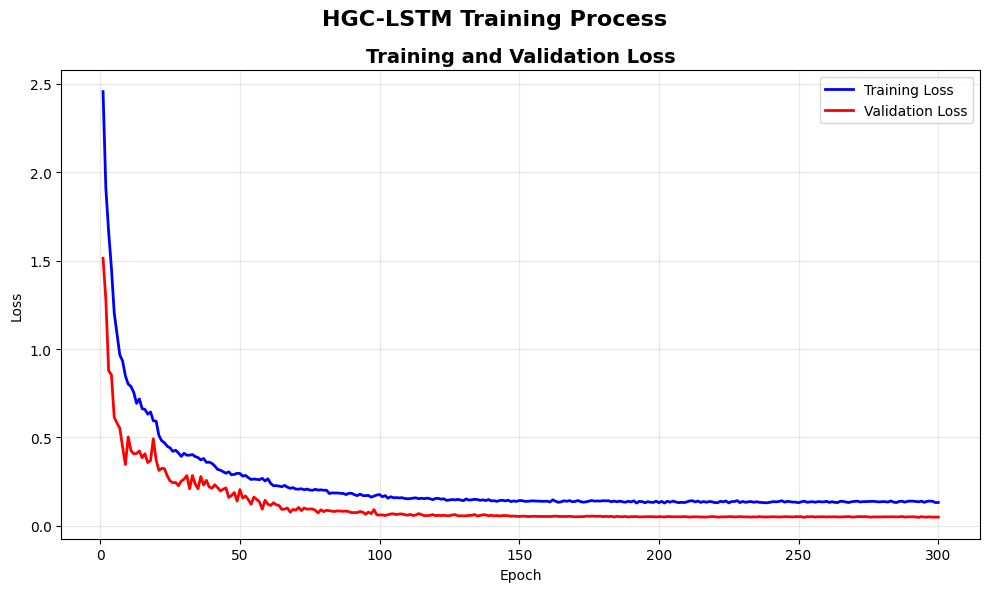

In [8]:
# Import visualization utilities
from src.utils.visualization_utils import visualize_training_triplet_process

# Visualize training process
print("[INFO] Generating training process visualization...")
training_fig = visualize_training_triplet_process(history, config, save_plots=True)

In [9]:
from src.utils.model_utils import load_model_triplet
import os
model_save_path = os.path.join(config.model.checkpoint_dir, config.model.save_name)
model = load_model_triplet(model_save_path, config)

Model loaded from outputs/models/best_hgc_lstm_embedding.pth


In [12]:
from scripts.inference import extract_embedding_from_video
import glob
from src.utils.detector import MediaPipeProcessor
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

test_dir = "data/datatest"  # Replace with your video path
videos = glob.glob(os.path.join(test_dir, "*.mp4"))
count = 0
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = MediaPipeProcessor(config)

# Load keypoints to embedding and add to database
X_db, y_db = [], []
keypoints_dir = "dataset/Keypoints"
keypoints = glob.glob(os.path.join(keypoints_dir, "*.npy"))

# Group keypoints by class number
class_samples = defaultdict(list)
for keypoint_path in keypoints:
    filename = os.path.basename(keypoint_path)
    number = int(filename.split('_')[0].split('.')[0])
    class_samples[number].append(keypoint_path)

# Take only 2 samples per class
print("[INFO] Building database with 2 samples per class...")
for class_num, samples in class_samples.items():
    # Take first 2 samples for each class
    selected_samples = samples[:5]
    
    for keypoint_path in selected_samples:
        embedding = model(torch.from_numpy(np.load(keypoint_path)).unsqueeze(0).float().to(device))
        embedding = embedding.cpu().detach().numpy()
        X_db.append(embedding)
        y_db.append(class_num)
    
    print(f"Class {class_num}: {len(selected_samples)} samples added")

# Convert to numpy arrays
X_db = torch.cat([torch.from_numpy(arr) for arr in X_db]).numpy()
y_db = np.array(y_db)

print(f"[INFO] Database built with {len(X_db)} total samples")
print(f"[INFO] Number of classes: {len(np.unique(y_db))}")
print(f"[INFO] Samples per class: {len(X_db) / len(np.unique(y_db)):.1f}")

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_db, y_db)

processor = MediaPipeProcessor(config)
for video_path in videos:
    filename = os.path.basename(video_path)
    number = int(filename.split('_')[1].split('.')[0])
    embedding = extract_embedding_from_video(model, processor, video_path, config, device)
    pred_label = knn.predict(embedding)
    print(f"{number}: {pred_label}")
    if number == pred_label:
        count += 1
print(f"{count}/{len(videos)} videos predicted correctly.")


[INFO] Building database with 2 samples per class...
Class 13: 5 samples added
Class 14: 5 samples added
Class 7: 5 samples added
Class 3: 5 samples added
Class 2: 5 samples added
Class 12: 5 samples added
Class 5: 5 samples added
Class 10: 5 samples added
Class 15: 5 samples added
Class 6: 5 samples added
Class 8: 5 samples added
Class 1: 5 samples added
Class 9: 5 samples added
Class 11: 5 samples added
Class 4: 5 samples added
[INFO] Database built with 75 total samples
[INFO] Number of classes: 15
[INFO] Samples per class: 5.0
14: [5]
4: [4]
9: [9]
13: [6]
10: [10]
1: [1]
11: [11]
6: [6]
2: [2]
7: [7]
3: [3]
5: [5]
8: [6]
12: [12]
15: [15]
12/15 videos predicted correctly.
